## Problem set 2 for EESCW4235 – Sea level change

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import interpolate as interp 
import scipy.optimize as opt
from scipy.interpolate import griddata
from scipy import interpolate as interp
from scipy.optimize import curve_fit as curve_fit
import numpy.polynomial.polynomial as poly

from cartopy import crs as ccrs
import cartopy.feature as cfeature
from matplotlib import path
from matplotlib import colorbar as colorbar
import cmocean

import pyshtools
from pathlib import Path

#### 1. Inferring sea level from Pleistocene coral

The picture below shows a part of a fossil branch of and Acropora Palmata that was found in the Bahamas and dates to the Last Interglacial. The top of the coral was found at an elevation of 3.2m and the measurement precision of the GPS is 50cm.

To investigate the indicative meaning, we
can use data on the present living depth range of Acropora Palmata from the ocean
biogeographic information system (OBIS). Show a histogram of the depths at which A. Palmata
are found today using the provided data in the excel sheet. Use this data to calculate the relative
water level and the indicative range for Acropora Palmata, which you can approximate as the
mean and twice the standard deviation of this dataset. Using this information, estimate how high
relative sea level (including uncertainty) was in the Bahamas during the Last Interglacial.

In [2]:
df = pd.read_csv('AP_depth_range.csv', skiprows=4)
df.head()

,A. palmata
0,0.55
1,0.55
2,0.55
3,0.55
4,0.55


<Figure size 432x432 with 0 Axes>

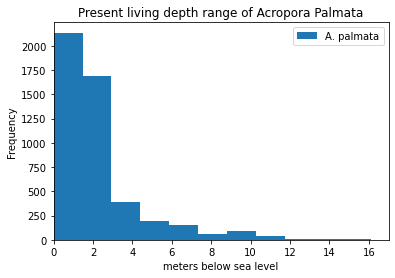

In [3]:
## plot histogram of a. palm living depth range
fig = plt.figure(figsize=(6,6))
ax = df.plot(kind='hist', bins= 15,
             title= 'Present living depth range of Acropora Palmata')
plt.xlabel('meters below sea level')
plt.xlim(0,17);

In [4]:
# mean present living depth range 
df.mean()

A. palmata    2.17292
dtype: float64

In [5]:
# standard deviation of present living depth range 
df.std()

A. palmata    2.169469
dtype: float64

In [6]:
palm_mean = 2.172
palm_std = 2.169
elev = 3.2
gps = 0.5

In [7]:
# relative water level: 
#average distance between sea level indicator and mean sea level 
RWL = -1*palm_mean

#indicative range:
#vertical range over which the indicator occurs 
IR = 2*palm_std

print(f'the Indicative Range of the A. Palmata is {IR} meters')

the Indicative Range of the A. Palmata is 4.338 meters


In [9]:
# Relative sea level 
RSL = elev - RWL

#error on RSL estimate 
sigmaRSL = np.sqrt(gps**2 + (palm_std)**2)
roundsigma = "{:.2f}".format(sigmaRSL)

print(f'the Relative sea level in the Bahamas during the Last Interglacial was {RSL} +/- {roundsigma} meters higher than today')

the Relative sea level in the Bahamas during the Last Interglacial was 5.372 +/- 2.23 meters higher than today


## 2. d18O balance

Use the oxygen isotope approach to estimate how much lower global mean sea level was during the last glacial maximum (LGM) compared to today. To estimate this you will need the values from the table below, the values from the Lisiecki and Raymo (2005) benthic oxygen stack (the first figure in lecture 10) and the equations we have used in class (during the breakout groups). Given that the Laurentide and Fennoscandian ice sheets were at a similar latitude than the present-day Greenland ice sheet, you can assume that excess ice during the LGM had the same d18O as the Greenland ice sheet does today.

Global mean sea level was around 120 – 130m lower during the last glacial maximum than it is today. How does this compare to your result and what are reasons for it to maybe differ?

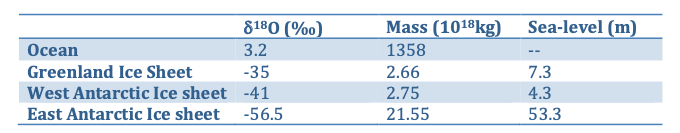

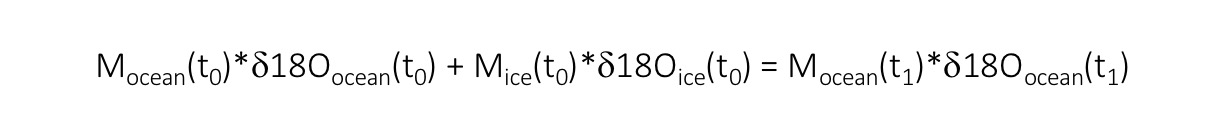

equations that I used:
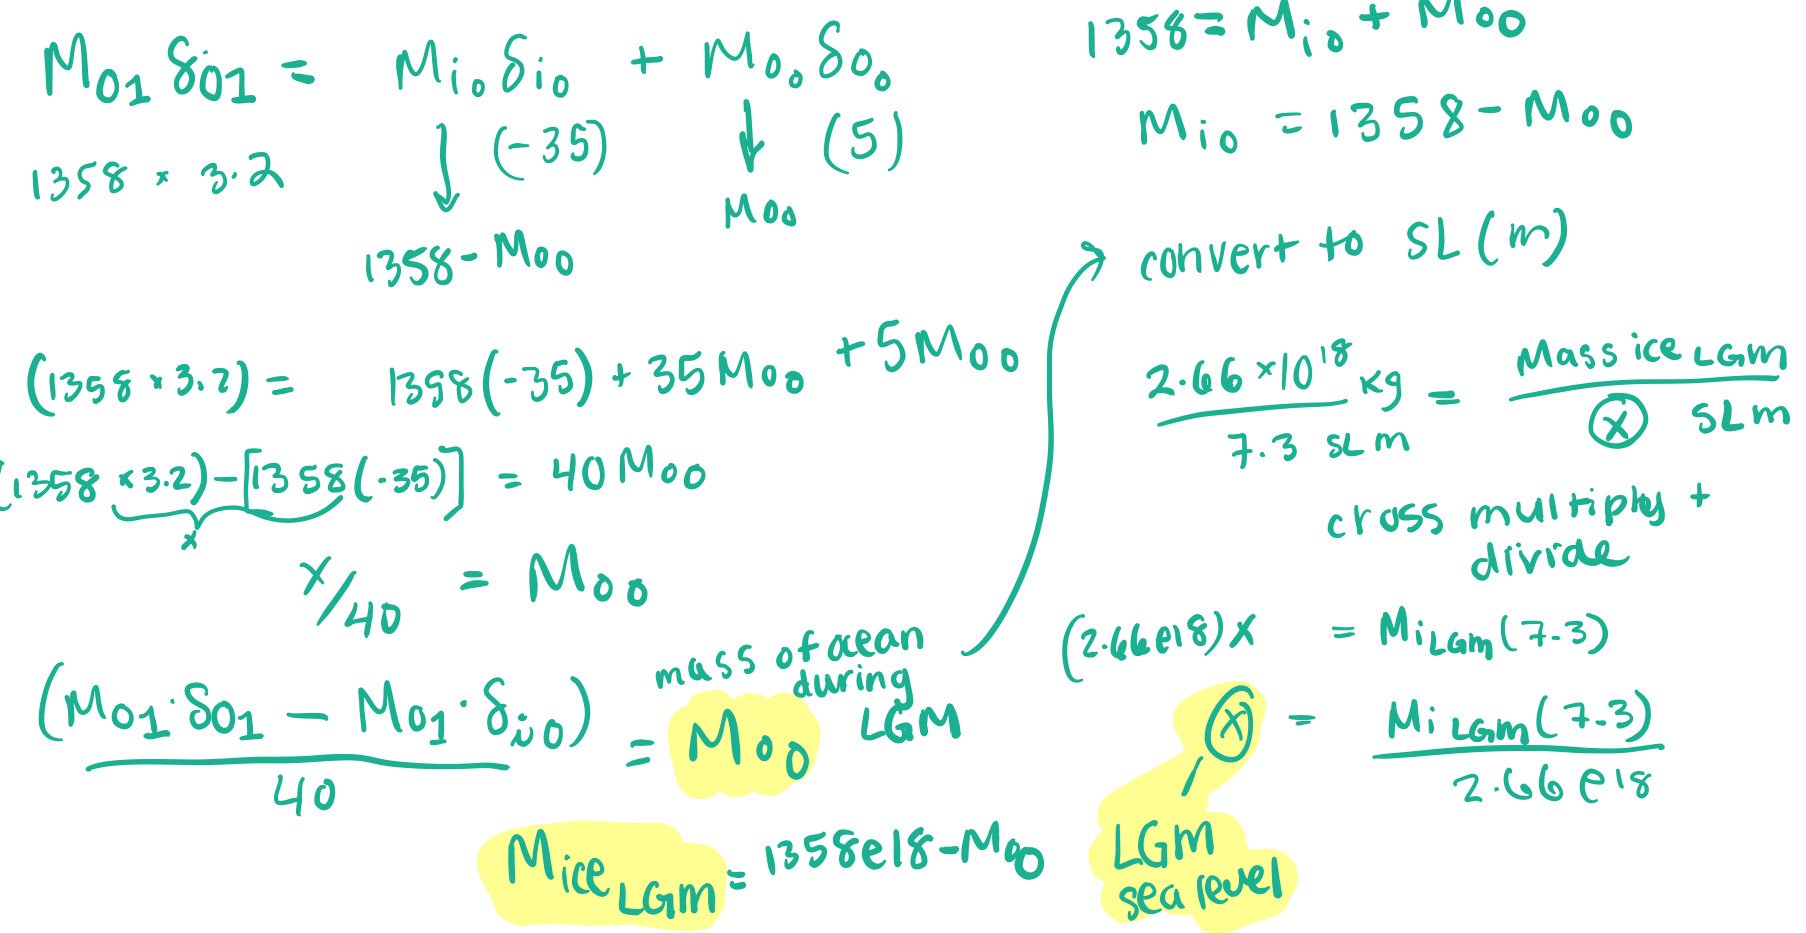

In [11]:
# mass of the ocean @ present day (t=1)
Moc1 = 1358e18 
# d18O of the ocean @ present day (t=1)
d18oc1 = 3.2

# d18O of the ocean @ LGM, estimated from the LR04 stack 
d18oc0 = 5
#  Laurentide and Fennoscandian ice sheets were at a similar latitude than the present-day 
# Greenland ice sheet, you can assume that excess ice during the LGM had the same d18O as the Greenland ice sheet does today.
# assumed d18O of ice at LGM 
d18ice0 = -35

In [44]:
Moc0 = (Moc1*d18oc1 - Moc1*d18ice0)/ 40
Mi0 = Moc1 - Moc0
print(f'The ice sheet mass during the LGM was {Mi0} kg')

The ice sheet mass during the LGM was 6.1110000000000066e+19 kg


In [40]:
lgmSL = (Mi0*7.3)/(2.66e18)
lgmSL
print(f'According to these calculations, LGM sea level was %.2f meters lower than today'%lgmSL)

According to these calculations, LGM sea level was 167.71 meters lower than today


#### Global mean sea level was around 120 – 130m lower during the last glacial maximum than it is today. How does this compare to your result and what are reasons for it to maybe differ?

My LGM sea level was 167.7 meters, so ~37.7-47.7 meters lower than the actual LGM value. Likely these two numbers differ becuase we assume that the d18O of all of the ice is equivalent to Greenland (-35 per mil). However, it is quite likely that there was also an Antarctic contribution (with a lower d18O). Accounting for that smaller d18O (more negative) would bring the sea level esimate closer to the 120-130m range. In addition, even though the Laurentide and Fennoscandian were at a similar latitude to Greenland, we can't assume that their d18O were exactly the same as Greenland. In addition, our ad hoc sea level conversion could be a large cause of the error - we should do a full GIA analysis because uplift and subsidence could change the basin shape and impact SL on the glacial-interglacial scale. 

## 3. Using spherical harmonics

#### Use spherical harmonics to calculate the mean ocean depth. To do that, follow these steps:

a) Load the topography provided for problem set 1 (etopo_15_ice) and construct the
ocean function, which is defined as C(lon,lat) = 1 in the oceans and C(lon,lat) = 0 on
land. Submit a figure showing a map of your ocean function.

In [4]:
# load etopo data
etopo = np.load('etopo_ice_15.npy')

lmax = 256
lreturn = 0

############## Reshape etopo
num1 = np.unique(etopo[:,0]).size #num of unique elements 
num2 = np.unique(etopo[:,1]).size
lon2 = np.reshape(etopo[:,0],(num1,num2)).T #reshape
lat2 = np.reshape(etopo[:,1],(num1,num2)).T
topo2 = np.reshape(etopo[:,2],(num1,num2)).T

topo_interp = interp.interp2d(lon2[1,:],lat2[:,1],topo2) #interp into 2D grid 
# interp func that interps from topo2 to a grid on gauss legendre grid 
# gauss legendre grid
# 2D x-y, then slice it 

############## Construct gauss legendre grid
# a grid on which its convienent to do transformations 
latglq, longlq = pyshtools.expand.GLQGridCoord(lmax) #to stay consistent with matlab
longlq2,latglq2 = np.meshgrid(longlq,np.sort(latglq)) #latglq should be in assending order

############## Interplate data onto grid
topoglq2 = topo_interp(longlq,latglq)
# interp the topo onto the gauss legendre grid 

# define an ocean function 
def ocean_function(topo):
    topo[topo > 0] = 0
    topo[topo < 0] = 1
    return topo 

oceanfunc_topo = ocean_function(topoglq2)

#topoglq2[topoglq2 > 0] = 0
#topoglq2[topoglq2 < 0] = 1

In [7]:
longlq.shape

(513,)

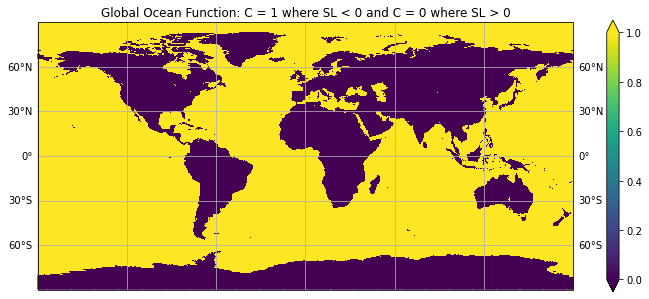

In [22]:
##Initial topography on GLQ grid
f1 = plt.figure(figsize=(12,10))
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

t1 = ax1.pcolormesh(longlq2,latglq2,oceanfunc_topo)

cb = f1.colorbar(t1, ax=ax1, shrink=0.50, extend='both')
# cb.set_label(label='Ocean Function',size=5)
plt.title('Global Ocean Function: C = 1 where SL < 0 and C = 0 where SL > 0')

plt.show()

b) Calculate the global average value of the ocean function using spherical harmonics.
What does this number represent? Consider whether you need to interpolate your ocean function onto a Gauss Legendre grid before doing the spherical harmonic transform.

In [39]:
############## Spherical harmonic transform
#compute weights and nodes that we need in order to perform spherical harmonics quadrature(grid)
zero, w = pyshtools.expand.SHGLQ(lmax)
# perform the transformation, exapnd a 2D grid on the Gauss-Legendre grid 
cilm = pyshtools.expand.SHExpandGLQC(oceanfunc_topo,w,zero,norm=1,csphase=1,lmax_calc=lmax)

############## Inverse Spherical harmonic transform
gridglq = pyshtools.expand.MakeGridGLQC(cilm,zero,lmax=lmax,norm=1,csphase=1,lmax_calc=lreturn)

globavg = gridglq.mean()
globavgreal = np.sign(globavg).real*np.abs(globavg)

print(f'The global average value of the ocean function (using spherical harmonics) is %.4f'%globavgreal)

The global average value of the ocean function (using spherical harmonics) is 0.7083


This number represents the percent of the world's surface that is covered by ocean (i.e. SL < 0) because ocean = 1 in the ocean function and land = 0 

c) Calculate the mean ocean depth using spherical harmonics. To do so construct a new field that is equal to topography but 0 on land. Calculate the global average of this field and then use your result from (b) to account for the fact that you don’t actually want the global average, but only the average in the ocean basins.

In [25]:
############## Interplate data onto grid
topoglq2 = topo_interp(longlq,latglq)
# interp the topo onto the gauss legendre grid 

# make a mask where any value > 0 is masked as a 0, but bathymetry values stay
oceanbath = topoglq2 # 0s on land 
oceanbath[topoglq2 > 0] = 0

############## Spherical harmonic transform
#compute weights and nodes that we need in order to perform spherical harmonics quadrature(grid)
zero, w = pyshtools.expand.SHGLQ(lmax)
# perform the transformation, exapnd a 2D grid on the Gauss-Legendre grid  
cilm = pyshtools.expand.SHExpandGLQC(oceanbath,w,zero,norm=1,csphase=1,lmax_calc=lmax)

############## Inverse Spherical harmonic transform
gridglq10 = pyshtools.expand.MakeGridGLQC(cilm,zero,lmax=lmax,norm=1,csphase=1,lmax_calc=lreturn)
tmp = np.sign(gridglq10).real*np.abs(gridglq10)

In [38]:
oceandepth = tmp.mean()/globavgreal
print(f'The mean ocean depth using spherical harmonics is %.0f meters below SL'%oceandepth)

The mean ocean depth using spherical harmonics is -3692 meters below SL


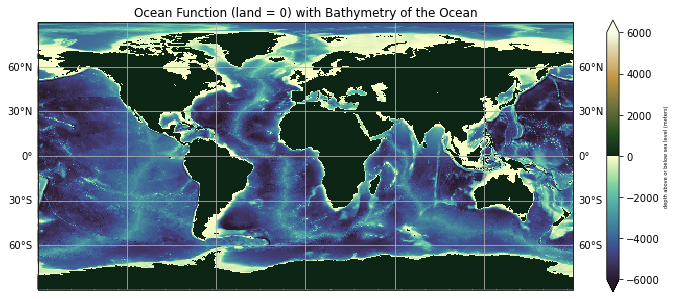

In [28]:
##Initial topography on GLQ grid
f1 = plt.figure(figsize=(12,10))
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

t1 = ax1.pcolormesh(longlq2,latglq2,topoglq2,cmap = cmocean.cm.topo, vmin=-6000, vmax=6000)

cb = f1.colorbar(t1, ax=ax1, shrink=0.50, extend='both')
cb.set_label(label='depth above or below sea level (meters)',size=5)
plt.title('Ocean Function (land = 0) with Bathymetry of the Ocean')
plt.show()

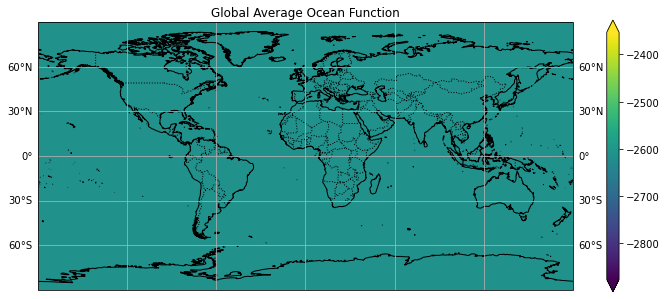

In [29]:
f1 = plt.figure(figsize=(12,10))
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

def add_features(ax):
    
    # add coastal features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    return ax

ax1 = add_features(ax1)
t1 = ax1.pcolormesh(longlq2,latglq2,tmp)
cb = f1.colorbar(t1, ax=ax1, shrink=0.50, extend='both')
# cb.set_label(label='Ocean Function',size=5)
plt.title('Global Average Ocean Function')
plt.show()

## 4. Earth’s viscosity

#### A relative sea level curve for Richmond Gulf, Hudson Bay, has been established on the basis of the dating of shell specimens. The age-height pairs for these samples are listed below.

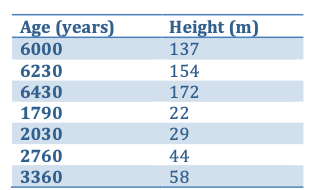

a) Determine the post-glacial decay time of Richmond Gulf using these data. Your answer should include a plot showing the data points and your best fitting curve. In addition to the data provided, consider that you also know the current relative sea level.

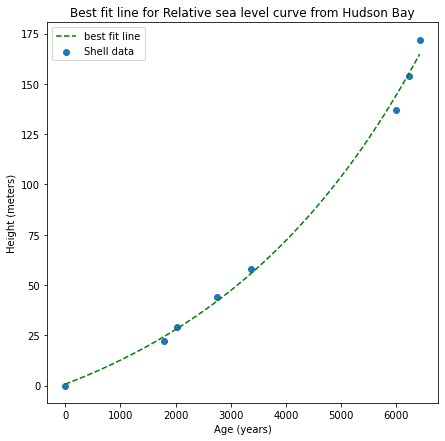

In [47]:
# create arrays of the age(years) and height(m) data 
ages = np.array([0,6000, 6230, 6430, 1790, 2030, 2760, 3360])
height = np.array([0,137, 154, 172, 22, 29, 44, 58])

# scipy curve_fit fits an exponential to the age/height data
params, covs = curve_fit(lambda x,a,b,c: a*np.exp(b*x)+c, ages,  height,  p0=(1, 0.001,0))

# grab the params, create a line of best fit
x = np.arange(0,6430,20)
y = params[0]*np.exp(params[1]*x) + params[2]


# plot the data and best fit curve
plt.figure(figsize=(7,7))

plt.scatter(ages,height,label='Shell data')
plt.plot(x,y,'--g',label='best fit line')

plt.xlabel('Age (years)')
plt.ylabel('Height (meters)')
plt.title('Best fit line for Relative sea level curve from Hudson Bay')
plt.legend();

In [50]:
# calculate post-glacial decay time, tau
# exp(-t/Tau) where t = ages
tau = 1/params[1] # tau in years
print(f'The post-glacial decay time (tau) of Richmond Gulf is %.2f years.'%tau)

#convert tau to seconds 
stau = tau * 3.154e7
print(f'Tau in seconds (neccessary for 4B) is {stau} seconds.')

The post-glacial decay time (tau) of Richmond Gulf is 4078.83 years.
Tau in seconds (neccessary for 4B) is 128646153663.6672 seconds.


b) Using this decay time estimate the average mantle viscosity below Canada. You can assume the following values: (pasted below) Over what depth in the mantle does this average apply?


In [54]:
# RSL(t) ~~ exp(-t/Tao)
# k = youngs modulus 
k = 1e11 # N/m2

# mantle density (rho m)
pm = 3000 # kg/m3

# depth of compensation (L)
L = 1200*1000 # km to meters

# gravity 9.8 m/s
g = 9.8

# alpha = k + pm*g*L
alpha = k + pm*g*L

#solve for nu = coeff of viscosity 
# n = coeff of viscosity
nu = stau*g*pm*k*L / alpha
print(f'Using the decay time from 4a, we estimate the average mantle viscosity below Canada is {nu:.3e} Pa s')

Using the decay time from 4a, we estimate the average mantle viscosity below Canada is 3.355e+21 Pa s


Over what depth in the mantle does this average apply?
Answer: over the depth of compensation (L) which is 1200km in this problem

## 5. Earth’ Maxwell time

a) What is the response (strain as a function of time) of a Maxwell viscoelastic material to the application of a constant stress rho(0)? To answer this question it might help to first think about what the strain is at time t = 0 and then solve the constitutive equation with this initial condition and assuming constant stress rho(0).

#### Response of a Maxwell viscelastic material to application of a constant stress rho(0) 
<div>
<img src="FullSizeRender-5.jpeg" width="500"/>
</div>

b) Draw a diagram of strain (y axis) as a function of time (x axis) and mark the elastic portion and the viscous portion.

#### Strain as a function of time 
<div>
<img src="FullSizeRender-3.jpeg" width="500"/>
</div>

c) Identify the elastic and viscous strains as a function of time, and provide an equation for the time tM at which these two are equal. What is the physical meaning of this time? Estimate this value for the Earth assuming a Young’s modulus of 1011 N/m2 and a viscosity of 1021 Pa*s.

#### An equation for the Maxwell time (tM), where elastic and viscous strains are equal to one another 
<div>
<img src="FullSizeRender-2.jpeg" width="400"/>
</div>

In [58]:
#tm = time at which both are equal, Maxwell Time

k = 1e11 # N/m2
nu = 1e21 # Pa s 

tm = nu/k
s_tm = tm * 3.17098e-8 # convert from seconds to years 
print(f'The Maxwell time for the Earth is {s_tm} years, given Youngs modulus and mantle viscosity')

The Maxwell time for the Earth is 317.098 years, given Youngs modulus and mantle viscosity


The Maxwell time (tM) is "the time after which half of the deformation is elastic and half is viscous." This is an important amount of time to quantify becuase both elastic and viscous deformation are acting on maxwell time and it acts as the cut off between the two regimes. 